# C4021 - Project
## Group 2.4
-  Brian Parle
-  Michel Danjou
-  Gerry Kerley 18195229
-  Gana Subramanian

### Team Contributions:
**Training data**
  * Gerry Kerley

**Pre-processing**
  * Gerry Kerley

**Algorithm training and evaluation**
  * Gerry Kerley

**Visualisation of outputs**
  * Gerry Kerley

**Code Review**
  * ?

### Dataset used
Titanic passenger survival:

https://www.kaggle.com/c/titanic/data

-  survival
    -  Survival	0 = No, 1 = Yes
-  pclass
    -  Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
-  sex
    -  Sex	
-  Age
    -  Age in years	
-  sibsp
    -  No. of siblings / spouses aboard the Titanic	
-  parch
    -  No. of parents / children aboard the Titanic	
-  ticket
    -  Ticket number	
-  fare
    -  Passenger fare	
-  cabin
    -  Cabin number	
-  embarked
    -  Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

### Machine Learning Algorithms
#### Logistic Regression
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#### Random Forests
https://scikit-learn.org/stable/modules/ensemble.html#random-forests
#### GridSearch
https://scikit-learn.org/stable/modules/ensemble.html#using-the-votingclassifier-with-gridsearch

## Data Loading & Preprocessing

### Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

### Load Titanic dataset

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

train.info()
train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
819,820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
503,504,0,3,"Laitinen, Miss. Kristina Sofia",female,37.0,0,0,4135,9.5875,NaN,S
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
741,742,0,1,"Cavendish, Mr. Tyrell William",male,36.0,1,0,19877,78.8500,C46,S


### Data Cleaning

#### Check for missing data

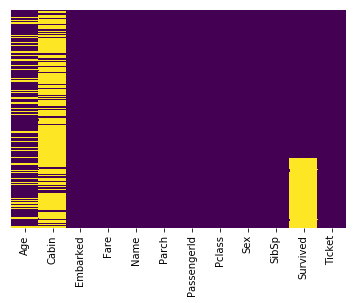

In [3]:
combined_data = pd.concat([train, test])
sns.heatmap(combined_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Age & Cabin have a lot of missing data.

Cabin number is probably not that important.

#### Fill missing Age data
Check whether the 3 passenger classes have different age distributions

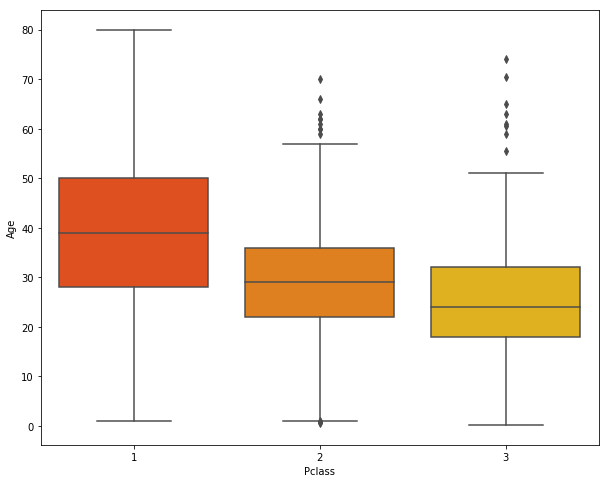

In [4]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Pclass',y='Age',data=combined_data,palette='autumn')

1st class tends to have older passengers so we can use the mean age for each class to fill in the blank ages.

In [5]:
def fill_missing_ages_with_mean_for_pclass (cols):
    Age = cols[0]
    Pclass = cols[1]   
          
    if pd.isnull(Age): 
        
        if Pclass == 1:            
            return np.mean(combined_data[combined_data['Pclass'] == 1 ]['Age'])

        elif Pclass == 2:
            return np.mean(combined_data[combined_data['Pclass'] == 2 ]['Age'])

        else:
            return np.mean(combined_data[combined_data['Pclass'] == 3 ]['Age'])

    else:
        return Age
    
combined_data['Age'] = combined_data[['Age','Pclass']].apply(fill_missing_ages_with_mean_for_pclass, axis=1)
combined_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


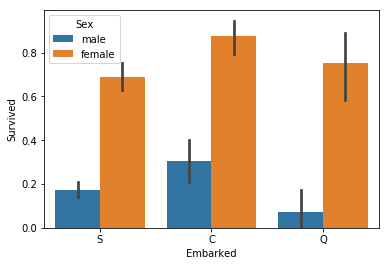

In [6]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=combined_data);

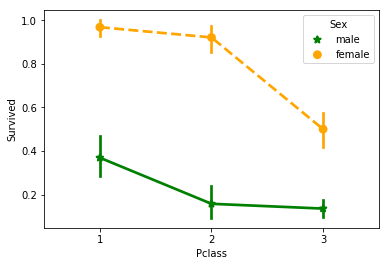

In [7]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=combined_data,
              palette={"male": "green", "female": "orange"},
              markers=["*", "o"], linestyles=["-", "--"]);

## Model Training & Testing

### Feature Engineering

In [8]:
def prepare_features(data):
    # Age - Categorise
    data.Age = data.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 20, 25, 40, 65, 120)
    categories = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    age_groups = pd.cut(data.Age, bins, labels=categories)
    data.Age = age_groups
        
    # Fare - fill blanks with mean
    data.fillna(value={'Fare': np.mean(data['Fare'])}, inplace=True)
    
    # SibSp (sibling/spouse) and Parch (Parent/Child) can determine if passengers travelled with family or alone
    data['TravelAlone']=np.where((data["SibSp"]+data["Parch"])>0, 0, 1)

    # Split Pclass (Social Class) into 3 
    train_Pclass_dummied = pd.get_dummies(data["Pclass"], prefix='Pclass', drop_first=True)
    data = pd.concat([data, train_Pclass_dummied], axis=1)
    
    # Drop columns
    unwanted_cols = ['SibSp', 'Parch', 'Embarked', 'Ticket', 'Name', 'Cabin']
    data.drop(unwanted_cols, axis=1, inplace= True)

    return data

combined_data = prepare_features(combined_data)
combined_data.head()

,Age,Fare,PassengerId,Pclass,Sex,Survived,TravelAlone,Pclass_2,Pclass_3
0,Student,7.2500,1,3,male,0.0,0,0,1
1,Young Adult,71.2833,2,1,female,1.0,0,0,0
2,Young Adult,7.9250,3,3,female,1.0,1,0,1
3,Young Adult,53.1000,4,1,female,1.0,0,0,0
4,Young Adult,8.0500,5,3,male,0.0,1,0,1


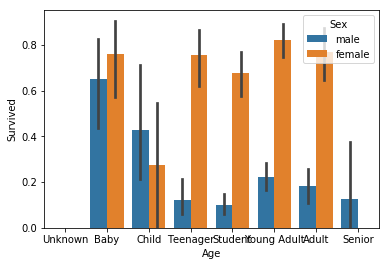

In [9]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=combined_data);

### Normalise labels
Use SKLearn's LabelEncoder to convert each unique string value into a number

In [10]:
def encode_features(combined_data):
    features = ['Age', 'Sex']
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(combined_data[feature])
        combined_data[feature] = le.transform(combined_data[feature])
    return combined_data
    
combined_data = encode_features(combined_data)
print(combined_data.head())

   Age     Fare  PassengerId  Pclass  Sex  Survived  TravelAlone  Pclass_2  \
0    4   7.2500            1       3    1       0.0            0         0   
1    6  71.2833            2       1    0       1.0            0         0   
2    6   7.9250            3       3    0       1.0            1         0   
3    6  53.1000            4       1    0       1.0            0         0   
4    6   8.0500            5       3    1       0.0            1         0   

   Pclass_3  
0         1  
1         0  
2         1  
3         0  
4         1  


#### Feature heatmap

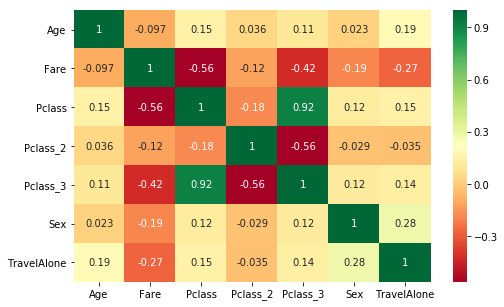

In [11]:
features = ['Age', 'Fare', 'Pclass', 'Pclass_2', 'Pclass_3', 'Sex', 'TravelAlone']
X = combined_data[features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## Training 
#### Split the Training Data

In [12]:
train_data = combined_data[combined_data['Survived'].notnull()]
test_data = combined_data[combined_data['Survived'].isnull()]
test_data = test_data.drop('Survived', axis=1)

X_all = train_data.drop(['Survived', 'PassengerId'], axis=1)
y_all = train_data['Survived']

test_proportion = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_proportion, random_state=42)

In [13]:
X_test.head()

,Age,Fare,Pclass,Sex,TravelAlone,Pclass_2,Pclass_3
709,4,15.2458,3,1,0,0,1
439,6,10.5000,2,1,1,1,0
840,5,7.9250,3,1,1,0,1
720,2,33.0000,2,0,0,1,0
39,5,11.2417,3,0,0,0,1


## Machine Learning
#### Fit, predict and fine tune the algorithms

### Logistic Regression

#### Feature importance

In [14]:
log_reg = LogisticRegression()
rfe = RFE(log_reg, 5)
fit = rfe.fit(X_train, y_train)
print(fit.n_features_)
print(np.asarray(train_data.columns.drop(['Survived', 'PassengerId'])))
print(rfe.ranking_)
print(rfe.support_)

5
['Age' 'Fare' 'Pclass' 'Sex' 'TravelAlone' 'Pclass_2' 'Pclass_3']
[2 3 1 1 1 1 1]
[False False  True  True  True  True  True]


#### Fit model and predict

In [15]:
log_reg.fit(X_train, y_train)
log_reg.score(X_train, y_train)

0.7837078651685393

In [16]:
lr_predictions = log_reg.predict(X_test)
lr_predictions

array([0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 1.])

In [18]:
ids = test_data['PassengerId']

predictions = log_reg.predict(test_data.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,1.0


In [19]:
confusion_matrix = confusion_matrix(y_test, lr_predictions)
confusion_matrix

array([[87, 18],
       [22, 52]])

In [20]:
print(accuracy_score(y_test, lr_predictions))

0.776536312849162


#### Cross Validation

In [21]:
scores = cross_val_score(log_reg, X_train, y_train, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.69014085 0.69444444 0.71830986 0.75       0.75714286 0.78873239
 0.8028169  0.80555556 0.88571429 0.94444444]
0.7837301587301587


In [22]:
# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

scores = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='accuracy')
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.72027972 0.72727273 0.79020979 0.79020979 0.79020979 0.7972028
 0.8041958  0.81118881 0.82517483 0.82517483]
0.788111888111888


#### Evaluation

In [23]:
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

         0.0       0.80      0.83      0.81       105
         1.0       0.74      0.70      0.72        74

   micro avg       0.78      0.78      0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



#### ROC curve

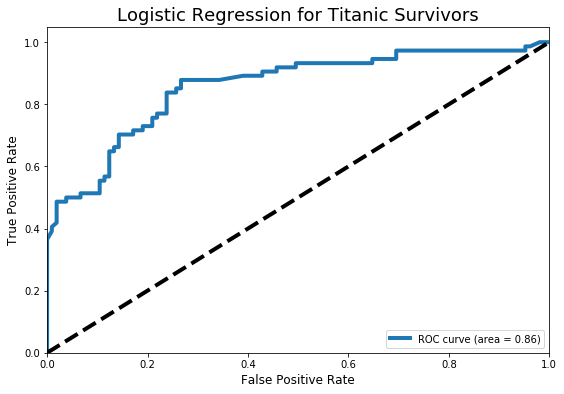

In [24]:
Y_score = log_reg.predict_proba(X_test)[:,1]

# Find the area under the curve
FPR, TPR, _ = roc_curve(y_test, Y_score)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve
plt.figure(figsize=[9,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Logistic Regression for Titanic Survivors', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Random Forest

In [25]:
rf_clf = RandomForestClassifier()

parameters = {'n_estimators': [4, 7, 10], 
              'max_features': ['log2', 'sqrt', 'auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

scorer = make_scorer(accuracy_score)

grid_search = GridSearchCV(rf_clf, parameters, scoring=scorer)
grid_search = grid_search.fit(X_train, y_train)

rf_clf = grid_search.best_estimator_

rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
rf_predictions = rf_clf.predict(X_test)
print(accuracy_score(y_test, rf_predictions))

0.7821229050279329


#### Cross validation

In [27]:
scores = cross_val_score(rf_clf, X_train, y_train, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.71428571 0.73239437 0.75       0.76056338 0.76388889 0.77464789
 0.83098592 0.83333333 0.88571429 0.91666667]
0.7962480438184664


#### Predict on Test Data

In [28]:
ids = test_data['PassengerId']

predictions = rf_clf.predict(test_data.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0.0
1,893,1.0
2,894,0.0
3,895,0.0
4,896,1.0


#### ROC curve

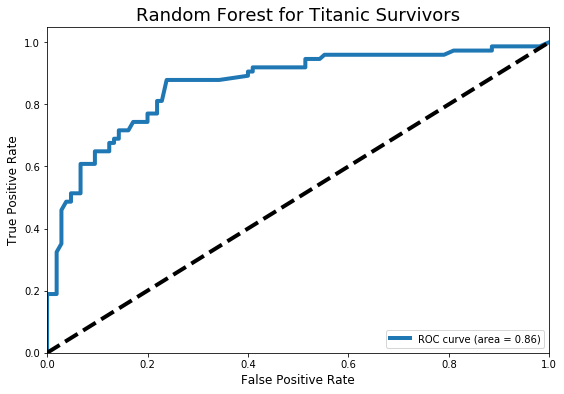

In [29]:
Y_score = rf_clf.predict_proba(X_test)[:,1]

# Find the area under the curve
FPR, TPR, _ = roc_curve(y_test, Y_score)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve
plt.figure(figsize=[9,6])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest for Titanic Survivors', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [30]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       105
         1.0       0.79      0.65      0.71        74

   micro avg       0.78      0.78      0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179

